This notebook presents an exemplary effect of implemented multispectral images preprocessing. 
<br>
The main aim is to **eliminate undesirable content such as clouds and shadows** for further use.

### Imports, drive mounting, defining constants

In [1]:
import tensorflow as tf
import numpy as np

# images
import cv2
import skimage.transform # for scaling multichannel (>3) images
from skimage.feature import greycomatrix, greycoprops
import matplotlib.pyplot as plt

# utils
from os import listdir
from google.colab import drive
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
LOAD_PATH = '/content/drive/My Drive/data/'

ORIGIN_IMG_DIM = 65 
BANDS = ['B4', 'B3', 'B2', 'B5', 'B6', 'B7', 'B10', 'B11'] 
NUM_CLASSES = 4 

BUFF_SIZE = 2048 
BATCH_SIZE = 32

### Image preprocessing functions

In [18]:
# preprocesses multispectral image regarding clouds
def preprocess_clouds(multispec_img, seg_img): # takes (single img from minibatch along with binary clouds / no clouds image)
  if np.sum(seg_img) / (65 * 65) <= 0.05: # clouds constitute no more than 5% of an image, it's okay
    return multispec_img, None 

  # use four sliding 50x50 windows to pick the part with the least clouds
  # slices numbers spatially:
  # 0 1 
  # 2 3
  slices = {
    0 : (slice(0, 50), slice(0, 50)),
    1 : (slice(0, 50), slice(15, 65)),
    2 : (slice(15, 65), slice(0, 50)),
    3 : (slice(15, 65), slice(15, 65)),
  }

  cloud_areas = np.zeros((4, ), dtype = int)

  # TODO: vectorize
  for i in range(4):
    cloud_areas[i] = np.sum(seg_img[slices[i]])

  min_quart = np.argmin(cloud_areas)
  if cloud_areas[min_quart] / (50 * 50)  <= 0.1: # if the best 50x50 slice contains less than 10% clouds
    return skimage.transform.resize(multispec_img[slices[min_quart]], (65, 65), preserve_range = True), slices[min_quart]

  # there's still to many clouds 
  return None

Below you can find a function that preprocesses RGB images regarding shadows. 
<br> Implementation is based on an idea from [this article](https://www.researchgate.net/publication/274563892_Shadow_Detection_and_Removal_from_a_Single_Image_Using_LAB_Color_Space#:~:text=A%20shadow%20detection%20method%20is,diffusion%20in%20the%20shadow%20boundary). 
<br>
The method's steps are the following:
* label each shadow separately;
* determine and label each shadow's neighbour pixels;
* for each shadow - calculate mean of R, G and B channels both for shadow and it's neighbours, then calculate their ratios and "neutralize" shadows by taking a product.
<br>
Additionaly, I used blur filter just for shadows borders to minimalize potential image distortions.

In [19]:
def preprocess_shadows(orig_img, single_chan_img): # (RGB image, binary shadow / no shadow image)
  if not np.any(single_chan_img == 0): # detect corrupted image 
    return None, None, None 

  if not np.any(single_chan_img): # no shadow at all
    return orig_img, np.zeros((65, 65)), np.zeros((65, 65))

  _, labels = cv2.connectedComponents(single_chan_img.astype(np.uint8)) # labeling shadows - make them separate objects
  labels = labels.astype(np.uint8) # assuming there will be no more than 255 shadows per image
  labels_dil = cv2.dilate(labels, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))) # for determining neighbours
  labeled_neighb = labels_dil - labels # neighbours with labels

  labels_max = labels.max()
  for l in range(1, labels_max + 1): # for each shadow in img
      rgb_img = orig_img.astype(np.float32)

      red_channel = rgb_img[:, :, 0]
      green_channel = rgb_img[:, :, 1]
      blue_channel = rgb_img[:, :, 2]

      # calculate mean ratios
      red_ratio = np.mean(red_channel[labeled_neighb == l]) / np.mean(red_channel[labels == l])
      green_ratio = np.mean(green_channel[labeled_neighb == l]) / np.mean(green_channel[labels == l])
      blue_ratio = np.mean(blue_channel[labeled_neighb == l]) / np.mean(blue_channel[labels == l])

      # restore "true" unshaded values of shaded pixels 
      red_channel[labels == l] = (red_ratio * red_channel[labels == l]).astype(np.uint8)
      green_channel[labels == l] = (green_ratio * green_channel[labels == l]).astype(np.uint8)
      blue_channel[labels == l] = (blue_ratio * blue_channel[labels == l]).astype(np.uint8)

      # blur to mitigate distortions
      red_blurred = cv2.blur(red_channel, (5, 5))
      green_blurred = cv2.blur(green_channel, (5, 5))
      blue_blurred = cv2.blur(blue_channel, (5, 5))

      red_channel[labeled_neighb == l] = red_blurred[labeled_neighb == l]
      green_channel[labeled_neighb == l] = green_blurred[labeled_neighb == l]
      blue_channel[labeled_neighb == l] = blue_blurred[labeled_neighb == l]

      orig_img[:, :, 0] = red_channel
      orig_img[:, :, 1] = green_channel
      orig_img[:, :, 2] = blue_channel

  return orig_img, labels, labeled_neighb

Below you can find a function that determines binary images (clouds and shadows detection) and displays the results.

In [29]:
def preprocess_show_batch(batch): # preprocesses and displays a batch
  batch = batch.numpy() 

  fig, axs = plt.subplots(32, 7)
  fig.set_size_inches(30, 100)

  for ax in axs: 
    for a in ax:
      a.axis('off')

  # precalculated TIRs channels minima and maxima
  TIRS_MIN = 153
  TIRS_MAX = 215

  for i in range(32): 
    rgb_img = batch[i, :, :, 0 : 3]

    axs[i, 0].imshow(rgb_img / np.max(rgb_img)) # / np.max(img_ready) for clearer visualization
    axs[i, 0].set_title('Original')

    tirs_mean = (batch[i, :, :, 6].astype(np.int16) + batch[i, :, :, 7].astype(np.int16)) / 2
    tirs_mean_norm = (tirs_mean - TIRS_MIN) / (TIRS_MAX - TIRS_MIN) # TIRs range of values are different than RGB hence normalization

    single_chan_img = np.zeros((ORIGIN_IMG_DIM, ORIGIN_IMG_DIM), dtype = np.int16) # int16 for negative values
    single_chan_img = batch[i, :, :, 2] - tirs_mean_norm

    # binarization for clouds
    single_chan_img[single_chan_img < 50] = 0
    single_chan_img[single_chan_img >= 50] = 1

    axs[i, 1].imshow(single_chan_img.astype(np.uint8))
    axs[i, 1].set_title('Binary (clouds / no clouds)')

    tup = preprocess_clouds(rgb_img, single_chan_img)

    if tup is None:
      axs[i, 2].set_title('Discarded due to clouds')
      continue

    (img_no_clouds, slices) = tup 

    axs[i, 2].imshow(img_no_clouds / np.max(img_no_clouds))
    axs[i, 2].set_title('After clouds preprocessing')

    # binarization for shadows
    single_chan_img = batch[i, :, :, 3] # using Near InfraRed (NIR)

    single_chan_img[single_chan_img < 40] = 1
    single_chan_img[single_chan_img >= 40] = 0

    if slices is not None: 
      single_chan_img = cv2.resize(single_chan_img[slices], (65, 65))

    axs[i, 3].imshow(single_chan_img.astype(np.uint8))
    axs[i, 3].set_title('Binary (shadows / no shadows)')

    img_ready, labels, labeled_neighb = preprocess_shadows(img_no_clouds, single_chan_img)

    if img_ready is None:
      axs[i, 4].set_title('Discarded due to shadows')
      continue

    axs[i, 4].imshow(labels)
    axs[i, 4].set_title('Labeled shadows')

    axs[i, 5].imshow(labeled_neighb)
    axs[i, 5].set_title('Labeled neighbours')
    
    axs[i, 6].imshow(img_ready / np.max(img_ready))
    axs[i, 6].set_title('Model input')

  fig.tight_layout()
  fig.show()

### Data loading and synthesizing

In [13]:
def filelist_from_folder(folder): # returns list of all TFRecords files inside a specified folder
  folder_path = LOAD_PATH + folder + '/'
  paths_list = []

  for filename in listdir(folder_path):
    if filename.startswith('part-') and not filename.endswith('gstmp'):
      paths_list.append(folder_path + filename)

  random.shuffle(paths_list) # make sure there's no order
  return paths_list

In [14]:
# what features to extract from TFRecord
features = {
  'B2': tf.io.FixedLenFeature([], tf.string), # B
  'B3': tf.io.FixedLenFeature([], tf.string), # G
  'B4': tf.io.FixedLenFeature([], tf.string), # R
  'B5': tf.io.FixedLenFeature([], tf.string), # NIR
  'B6': tf.io.FixedLenFeature([], tf.string), # SWIR1
  'B7': tf.io.FixedLenFeature([], tf.string), # SWIR2
  'B10': tf.io.FixedLenFeature([], tf.string), # TIR1
  'B11': tf.io.FixedLenFeature([], tf.string), # TIR2
  'label': tf.io.FixedLenFeature([], tf.int64)}   

In [15]:
def getband(example_key): # returns one channel, (65, 65, 1) tensor
  img = tf.io.decode_raw(example_key, tf.uint8) 

  return tf.reshape(img[ : ORIGIN_IMG_DIM**2], shape = (ORIGIN_IMG_DIM, ORIGIN_IMG_DIM, 1)) 

def _parse_(serialized_example, keylist):
  example = tf.io.parse_single_example(serialized_example, features) # transforms serialized binary sequence to a dictionary with
                                                                     # assigned sequences
  bandlist = [getband(example[key]) for key in keylist]
  image = tf.concat(bandlist, -1) # join all channels
  label = tf.cast(example['label'], tf.int32) 
  label = tf.one_hot(label, NUM_CLASSES)

  return image, label 

def parse_tfrecords(paths_list): #  'In practice, we use buffer size equals to several batch sizes.'
  dataset = tf.data.TFRecordDataset(paths_list) 
  dataset = dataset.map(lambda x : _parse_(x, BANDS))
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [16]:
# create a list of TFRecords
train_tfrecords = filelist_from_folder('train')
train = parse_tfrecords(train_tfrecords)

it = iter(train)
batch, _ = next(it) # load one minibatch

### Visualization



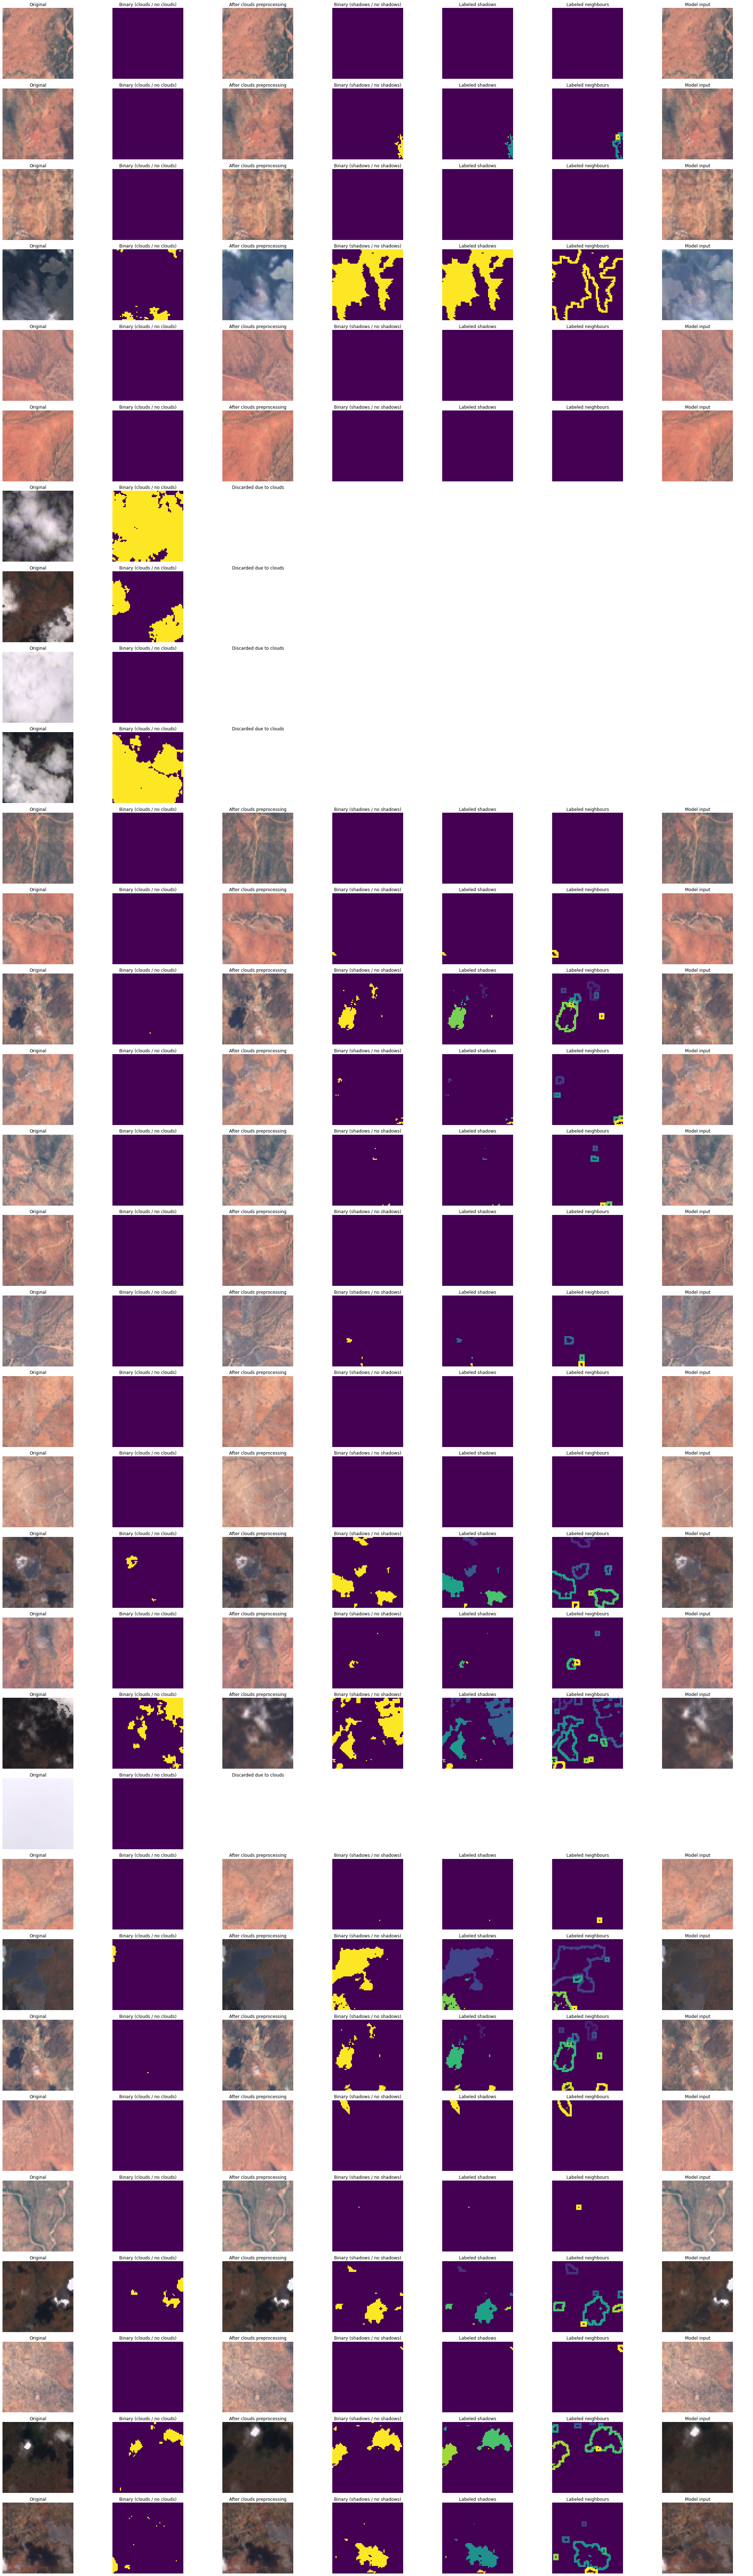

In [30]:
preprocess_show_batch(batch)